In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

In [5]:
from narrative import nar181026_heat_confidence_genes

from narrative import nar181205_networks

In [6]:
from scipy.stats import spearmanr

In [7]:
save_images = False

In [8]:
ref_genes = standardizer.reference_genes(10090, 'orp')

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [9]:
pr = properties.genbank_validated_rna(10090)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])

In [10]:
from natsort import natsorted

In [11]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')

tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 


de_set = all_de[
    (all_de['tissue'].isin(tissues_to_consider)) & 
    (all_de['pfu']==0) &
    (all_de['younger']==4) &   
    (all_de['de_unit']=='both') & 
    (all_de['padj'].notnull()) &
    (all_de['gene_ncbi'].isin(ref_genes))

]



In [12]:
from itertools import product

In [13]:
onditions = natsorted(de_set['condition'].unique())
ages = de_set['older'].unique()
out = pd.DataFrame(index=tissues_to_consider, columns=ages)


for tissue, age in product(tissues_to_consider, ages):

    d = de_set[
        (de_set['older']==age) &
        (de_set['tissue']==tissue)
    ]

    d = d[['gene_ncbi', 'o_over_y']].dropna()
    d = pd.merge(d, pr)

    r, p = spearmanr(d['log_length'], d['o_over_y'])
    d = d.set_index('gene_ncbi')

    out.loc[tissue, age] = r

In [14]:
out.loc[out.loc[:, 24]<0, 24].sort_values().rank(pct=True)

Blood         0.071429
Kidney        0.142857
SI            0.214286
LI            0.285714
Stomach       0.357143
BAT           0.428571
Esophagus     0.500000
GutEP         0.571429
Heart         0.642857
Adrenal       0.714286
MuscSat       0.785714
WAT           0.857143
Liver         0.928571
Cerebellum    1.000000
Name: 24.0, dtype: float64

In [15]:
out.loc[out.loc[:, 24]<0, 24].sort_values()

Blood         -0.646453
Kidney        -0.599801
SI            -0.548157
LI            -0.522198
Stomach       -0.438255
BAT           -0.334887
Esophagus     -0.310671
GutEP         -0.254853
Heart         -0.199111
Adrenal       -0.162002
MuscSat       -0.135331
WAT           -0.120297
Liver        -0.0708833
Cerebellum   -0.0331095
Name: 24.0, dtype: object

In [16]:
from natsort import natsorted

In [17]:
conditions = natsorted(all_de['condition'].unique())

In [18]:
condition = 'Esophagus_0_4_24'

In [19]:
d = all_de[
    (all_de['condition']==condition) & 
    (all_de['is_detected']==True) & 
    (all_de['de_unit']=='both') & 
    (all_de['gene_ncbi'].isin(ref_genes))
]

In [20]:
e = pd.merge(d[['gene_ncbi', 'o_over_y', 'padj']], pr[['gene_ncbi', 'log_length']])

In [21]:
e.loc[:, 'is_significant'] = e['padj'] < 0.05

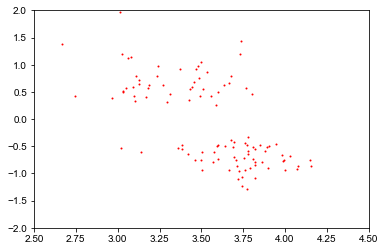

In [22]:

f = e['padj'] < 0.05
plt.scatter(
    e.loc[f, 'log_length'], e.loc[f, 'o_over_y'], c='red', s=1)

plt.ylim([-2, 2])
plt.xlim([2.5, 4.5])

if save_images:
    export.export_image(
        '200513_visualize_imbalance_and_significant_genes/sole_scatter.pdf')




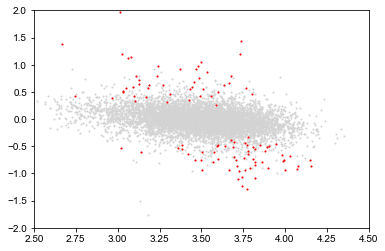

In [23]:
plt.scatter(
    e.loc[:, 'log_length'], e.loc[:, 'o_over_y'], c='lightgrey', s=1)


f = e['padj'] < 0.05
plt.scatter(
    e.loc[f, 'log_length'], e.loc[f, 'o_over_y'], c='red', s=1)

plt.ylim([-2, 2])
plt.xlim([2.5, 4.5])

if save_images:
    export.export_image(
        '200513_visualize_imbalance_and_significant_genes/light_scatter.pdf')



In [24]:
e.corr('spearman')

,gene_ncbi,o_over_y,padj,log_length,is_significant
gene_ncbi,1.000000,0.011174,0.068809,0.155560,-0.057328
o_over_y,0.011174,1.000000,0.058098,-0.310671,-0.024417
padj,0.068809,0.058098,1.000000,-0.015091,-0.212990
log_length,0.155560,-0.310671,-0.015091,1.000000,0.028871
is_significant,-0.057328,-0.024417,-0.212990,0.028871,1.000000


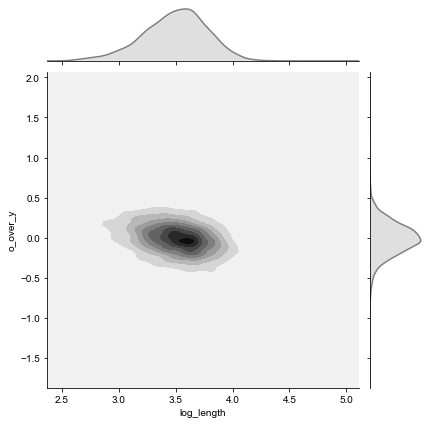

In [25]:
sns.jointplot(x='log_length', y='o_over_y', data=e, kind='kde',color='grey')

if save_images:
    export.export_image(
        '200513_visualize_imbalance_and_significant_genes/grey.pdf')



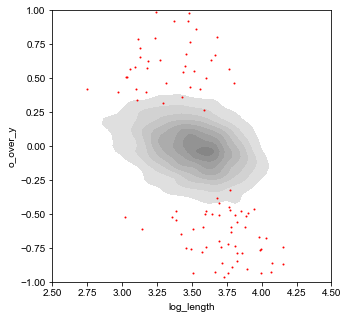

In [26]:
plt.figure(figsize=(5, 5))

sns.kdeplot(
    e.loc[:, 'log_length'], e.loc[:, 'o_over_y'], color='gray',shade=True, shade_lowest=False)


f = e['padj'] < 0.05
plt.scatter(
    e.loc[f, 'log_length'], e.loc[f, 'o_over_y'], c='red', s=1)

plt.ylim([-1, 1])
plt.xlim([2.5, 4.5])

if save_images:
    export.export_image(
        '200513_visualize_imbalance_and_significant_genes/hybrid_scatter.pdf')




In [27]:
e['up'] = e['o_over_y']>0
e[f]['up'].value_counts()

False    58
True     46
Name: up, dtype: int64